In [60]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import math
import random

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import datetime as dt
import os
np.random.seed(7)

from scipy.spatial import distance
from numpy.random import choice
import math
from scipy import stats
from scipy import optimize

from scipy import stats
from statsmodels.stats import contingency_tables
import torch.nn as nn
import torch.nn.functional as F
import torch 

from tqdm import tqdm

In [27]:
import matplotlib as mpl

mpl.use('svg')
new_rc_params = {
    "font.size": 20, #choosing the font size helps latex to place all the labels, ticks etc. in the right place
    "svg.fonttype": 'none',
    'figure.max_open_warning': 0
} 

mpl.rcParams.update(new_rc_params)
#     "font.weight":700
plt.rcParams['axes.facecolor'] = (1, 1.0, 1, 1)
plt.rcParams['figure.facecolor'] = (1.0, 1, 1, 1.0)
plt.rcParams['savefig.facecolor'] = (1, 1.0, 1.0, 1)

my_font_dict = {
        'size': 20,
        }

In [28]:
def color_axes(axes_):
    axes_.spines['bottom'].set_color('black')
    axes_.spines['top'].set_color('black') 
    axes_.spines['right'].set_color('black')
    axes_.spines['left'].set_color('black')
    axes_.grid(color='black', linestyle='-', linewidth=0.3)

In [31]:
data = pd.read_csv('data/DataAllSubjectsRewards.csv')
data.fillna(-1, inplace=True)
with open('Data/huge_pd_shuffled_with_rewards_original_seq4_SHUFFLED.pkl', 'rb') as f: # load sequences dataset
    train_data = pickle.load(f)

In [32]:
train_data

,index,user,choice,reward,time,payoff_structure,reward_1,reward_2,reward_3,reward_4,orig_choice_num,prev_choice,prev_reward
412,104,734,4,38,1210.0,4,43,50,58,38,108,4,57
413,105,734,1,33,629.0,4,33,38,54,39,109,4,38
414,106,734,1,32,465.0,4,32,43,63,39,110,1,33
415,107,734,1,27,532.0,4,27,42,52,35,111,1,32
408,103,73,3,83,1277.0,2,31,54,83,50,104,2,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,77,171,3,43,640.0,2,48,59,43,39,77,2,56
400,101,108,2,62,785.0,2,38,62,80,34,102,1,28
401,102,108,1,36,854.0,2,36,62,82,43,103,2,62
402,103,108,2,54,844.0,2,31,54,83,50,104,1,36


In [159]:
# make prediction for each seq of 4

seq_length = 4
# Copy dataframe
cur_data = train_data.copy()

# Index choices in [[0, 3]]
cur_data['choice'] = cur_data.choice.apply(lambda x: x - 1)
cur_data['prev_choice'] = cur_data.prev_choice.apply(lambda x: x - 1)

# Select prev_choice and prev_reward columns to prepare the observed choices data
X = cur_data.drop(columns=['index', 'choice', 'user', 'time', 'reward', 'payoff_structure', 'reward_1', 'reward_2', 'reward_3', 'reward_4'])

# Select current choice to prepare the choice to predict
y = cur_data.choice

# One hot encoding previous choices
num_of_classes = len(y.unique()) #4
X_prev = X.prev_choice.to_numpy()
X_prev = F.one_hot(torch.tensor(X_prev, dtype = torch.int64), num_classes=num_of_classes)

# One hot encoding current choices
num_of_classes = len(y.unique())
y = y.to_numpy()
y = F.one_hot(torch.tensor(y, dtype=torch.int64), num_classes = num_of_classes)

# Create the array of previous choice and previous rewards to prepare X tensor
new_X = []
for prev_choice, prev_reward in zip(X_prev, X.prev_reward):
    new_i = np.append(prev_choice, prev_reward) # Concatenates the prev_choice (one hot vector of size 4) and the prev reward
    new_X.append(new_i)

new_X = np.array(new_X)

possible_samples = int(new_X.shape[0] / seq_length)

# reshape X to be [samples, time steps, features] xx NO : time steps, samples, features
new_X = np.reshape(new_X, (possible_samples, seq_length, new_X.shape[1]))
new_X.shape
y = np.reshape(y, (possible_samples, seq_length, y.shape[1]))

In [275]:
HIDDEN_SIZE = 64

class Model(nn.Module):
    """
    LSTM model for choice prediction
    """
    def __init__(self, input_size = 5, output_size = 4, hidden_size=HIDDEN_SIZE):
        super(Model, self).__init__()

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)  # input shape [N, L, H]
        self.linear_layer = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim = 1)
    def forward(self, x):
        output, _ = self.lstm(x) # output shape [N, L, H]
        probs = self.softmax(self.linear_layer(output[:, -1, :])) # output shape [N, 4]
        return probs
    

def explicit_prediction_1(x_seq, eps = 0.005): 
    rewards = x_seq[:, -1]
    best_rewards = np.where(rewards == np.max(rewards))[0]
    best_choices = x_seq[best_rewards, :-1].argmax()
    next_choice_probs = np.zeros(4)
    next_choice_probs[best_choices] = 1/len(best_rewards) - (4-len(best_rewards))/len(best_rewards) * eps
    next_choice_probs[next_choice_probs==0] = (len(best_rewards))/(4.00001-len(best_rewards)) * eps # avoiding division by 0
    return next_choice_probs

In [276]:
model_path = "saved_model/general_full_data_training/torch_model"
general_model = Model(input_size = 5)
general_model.load_state_dict(torch.load(model_path))
general_model.eval()

model_path = "saved_model/no_reward_full_data_training/torch_model"
no_reward_model = Model(input_size = 4)
no_reward_model.load_state_dict(torch.load(model_path))
no_reward_model.eval()

model_comparison_df = pd.DataFrame(columns = ['user', 'payoff_structure', 'orig_choice_num', 'prev_choice_sequence', 'prev_reward_sequence', 'general_pred', 'nr_pred', 'explicit_pred', 'true_choice'], index = np.arange(0, new_X.shape[0], 1))
for k in tqdm(range(new_X.shape[0])):
    probs = general_model(torch.tensor(new_X[k, :, :], dtype = torch.float32).unsqueeze(0))
    _, predictions = torch.max(probs, 1)   # compute accuracy
    model_comparison_df['general_pred'][k] = predictions.detach().numpy()
    
    probs = no_reward_model(torch.tensor(new_X[k, :, :-1], dtype = torch.float32).unsqueeze(0))
    _, predictions = torch.max(probs, 1)   # compute accuracy
    model_comparison_df['nr_pred'][k] = predictions.detach().numpy()
    
    model_comparison_df['explicit_pred'][k] = explicit_prediction_1(new_X[k, :, :], eps = 0).argmax()
    
    model_comparison_df['prev_choice_sequence'][k] = new_X[k, :, :-1].argmax(axis = -1)
    model_comparison_df['prev_reward_sequence'][k] = new_X[k, :, -1]
    
    model_comparison_df['true_choice'][k] = y[k, -1, :].argmax(axis = -1).detach().numpy().item()
    model_comparison_df['user'][k] = train_data['user'].iloc[4*k]
    model_comparison_df['orig_choice_num'][k] = train_data['user'].iloc[4*k+3]
    model_comparison_df['payoff_structure'][k] = train_data['payoff_structure'].iloc[4*k]

100%|██████████| 135956/135956 [37:28<00:00, 60.47it/s] 


In [202]:
model_comparison_df.to_csv('model_comparison_over_data')

In [279]:
(model_comparison_df['explicit_pred'] == model_comparison_df.true_choice).mean()

0.7081335137838712

#### Accuracies per person

In [18]:
def create_scatter_all_payoffs(all_dfs, x_axis, y_axis, add_text='', save_fig=False, save_format='svg'):
    """
    scater of participants accuracy of all 3 payoffs with 2 model types. 
    notice that the order of the dfs passed HAS to be the same order as 2,3,4 .
    """
    plt.clf()
    sns.set(rc={'figure.figsize':(12,12)})
    comparison_title = '{} VS {}'.format(x_axis, y_axis, fontdict=my_font_dict)
    
    
    ax = sns.scatterplot(x=x_axis, y=y_axis, data=all_dfs,hue='Payoff',legend='full', palette=['r','g','b'])
    
    plt.title("All payoffs participants accuracy comparison {} {}".format(comparison_title, add_text), fontdict=my_font_dict)
    
    x1, y1 = [0, 1], [0, 1]
#     plt.legend(['payoff_2','payoff_3','payoff_4'])
    plt.plot(x1, y1,'k--', marker = 'x')
    plt.tick_params(axis='both', labelsize=20)
    if save_fig:
        if save_format=='svg':
            plt.savefig(os.path.join(saving_dir,'payoff_participant_accuracy_comparison_{}.svg'.format(comparison_title.replace(" ","_"))),quality=95,dpi=200, format='svg')
        else:
            plt.savefig(os.path.join(saving_dir,'payoff_participant_accuracy_comparison_{}.png'.format(comparison_title.replace(" ","_"))),quality=95,dpi=200)
    plt.show()
#     mpl.get_backend()

In [292]:
model_comparison_df['true_false_gen_pred'] = model_comparison_df['general_pred'] == model_comparison_df['true_choice']
model_comparison_df['true_false_nr_pred'] = model_comparison_df['nr_pred'] == model_comparison_df['true_choice']
model_comparison_df['true_false_explicit_pred'] = model_comparison_df['explicit_pred'] == model_comparison_df['true_choice']

general_payoff2_accs = model_comparison_df[model_comparison_df.payoff_structure == 2].groupby(['user'])['true_false_gen_pred'].mean()
general_payoff3_accs = model_comparison_df[model_comparison_df.payoff_structure == 3].groupby(['user'])['true_false_gen_pred'].mean()
general_payoff4_accs = model_comparison_df[model_comparison_df.payoff_structure == 4].groupby(['user'])['true_false_gen_pred'].mean()

nr_payoff2_accs = model_comparison_df[model_comparison_df.payoff_structure == 2].groupby(['user'])['true_false_nr_pred'].mean()
nr_payoff3_accs = model_comparison_df[model_comparison_df.payoff_structure == 3].groupby(['user'])['true_false_nr_pred'].mean()
nr_payoff4_accs = model_comparison_df[model_comparison_df.payoff_structure == 4].groupby(['user'])['true_false_nr_pred'].mean()

explicit_payoff2_accs = model_comparison_df[model_comparison_df.payoff_structure == 2].groupby(['user'])['true_false_explicit_pred'].mean()
explicit_payoff3_accs = model_comparison_df[model_comparison_df.payoff_structure == 3].groupby(['user'])['true_false_explicit_pred'].mean()
explicit_payoff4_accs = model_comparison_df[model_comparison_df.payoff_structure == 4].groupby(['user'])['true_false_explicit_pred'].mean()

In [293]:
model_comparison_df.payoff_structure.unique()

array([4, 2, 3])

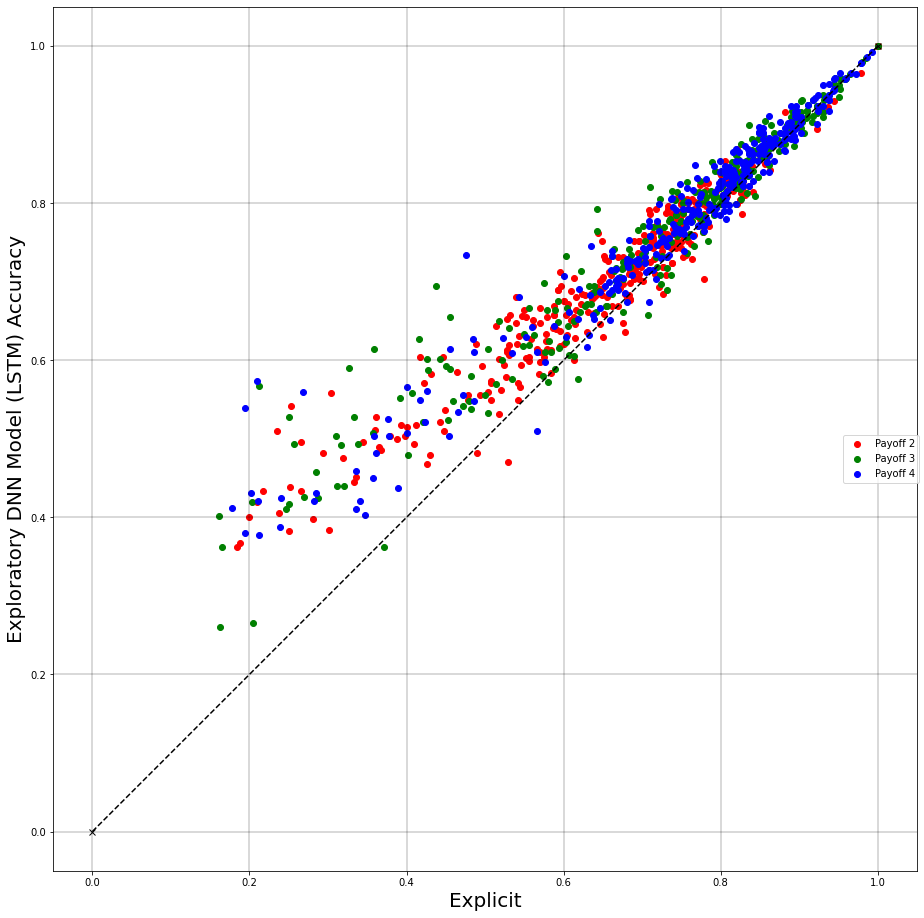

<Figure size 432x288 with 0 Axes>

In [294]:
%matplotlib inline

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1, 1, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1, 1.0, 1, 1),  # white
    "savefig.facecolor": (1, 1.0, 1.0, 1),  # blue  with alpha = 20%
})

x_range = np.arange(4,150)
fig=plt.figure(figsize=(12,12))
ax=fig.add_axes([0,0,1,1])
ax.scatter(x=explicit_payoff2_accs, y=general_payoff2_accs, color ='r')
ax.scatter(x=explicit_payoff3_accs, y=general_payoff3_accs, color ='g')
ax.scatter(x=explicit_payoff4_accs, y=general_payoff4_accs, color ='b')
fig.legend(['Payoff 2','Payoff 3','Payoff 4'], loc= 'right')

x1, y1 = [0, 1], [0, 1]
plt.plot(x1, y1,'k--', marker = 'x')
ax.set_xlabel('Explicit', fontdict=my_font_dict)
ax.set_ylabel('Exploratory DNN Model (LSTM) Accuracy', fontdict=my_font_dict)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='black', linestyle='-', linewidth=0.3)

plt.show()

plt.savefig(os.path.join(saving_dir,'all_payoffs_participant_accuracy_comparison_scatterplot_LSTM_VS_Qlearning.svg'),dpi=200, format='svg')

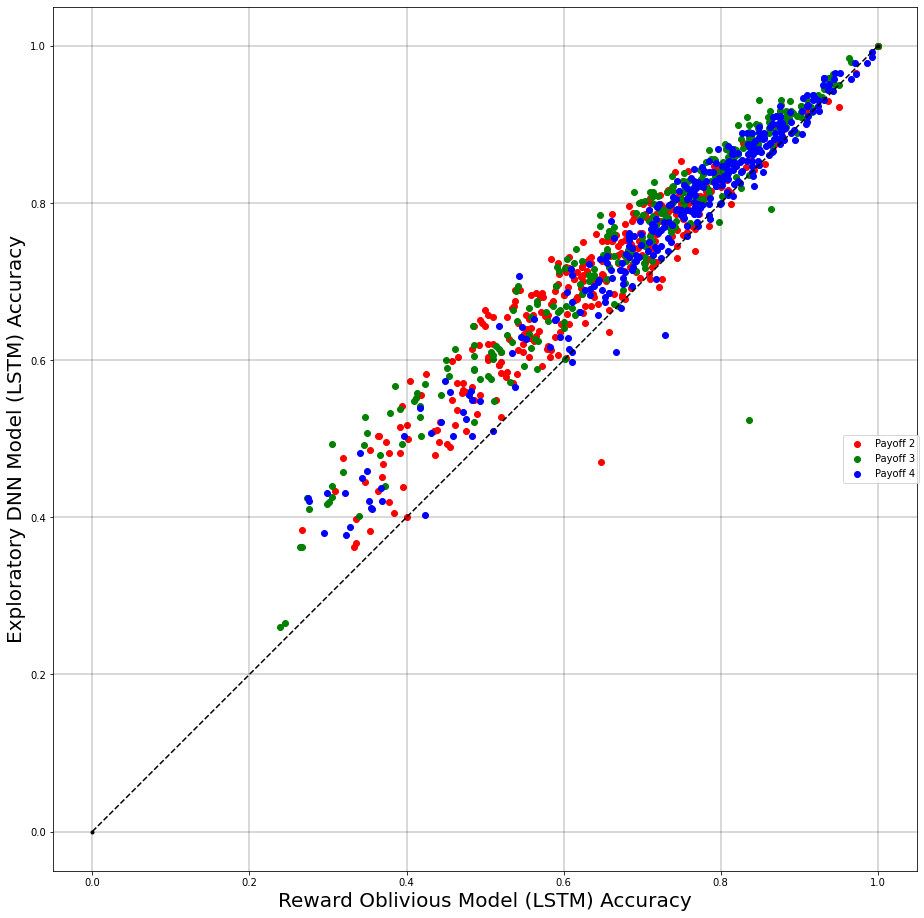

<Figure size 432x288 with 0 Axes>

In [298]:

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1, 1, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1, 1.0, 1, 1),  # white
    "savefig.facecolor": (1, 1.0, 1.0, 1),  # blue  with alpha = 20%
})

x_range = np.arange(4,150)
fig=plt.figure(figsize=(12,12))
ax=fig.add_axes([0,0,1,1])
ax.scatter(x=nr_payoff2_accs, y=general_payoff2_accs, color ='r')
ax.scatter(x=nr_payoff3_accs, y=general_payoff3_accs, color ='g')
ax.scatter(x=nr_payoff4_accs, y=general_payoff4_accs, color ='b')
fig.legend(['Payoff 2','Payoff 3','Payoff 4'], loc= 'right')

x1, y1 = [0, 1], [0, 1]
plt.plot(x1, y1,'k--', marker = '.')
ax.set_xlabel('Reward Oblivious Model (LSTM) Accuracy', fontdict=my_font_dict)
ax.set_ylabel('Exploratory DNN Model (LSTM) Accuracy', fontdict=my_font_dict)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='black', linestyle='-', linewidth=0.3)

plt.show()

plt.savefig(os.path.join(saving_dir,'all_payoffs_participant_accuracy_comparison_scatterplot_LSTM_VS_Reward_Oblivious.svg'),dpi=200, format='svg')

explain/one_stop_shop/updated_qlearning_paper_addition/feb_2022/Participants accuracies panel.svg


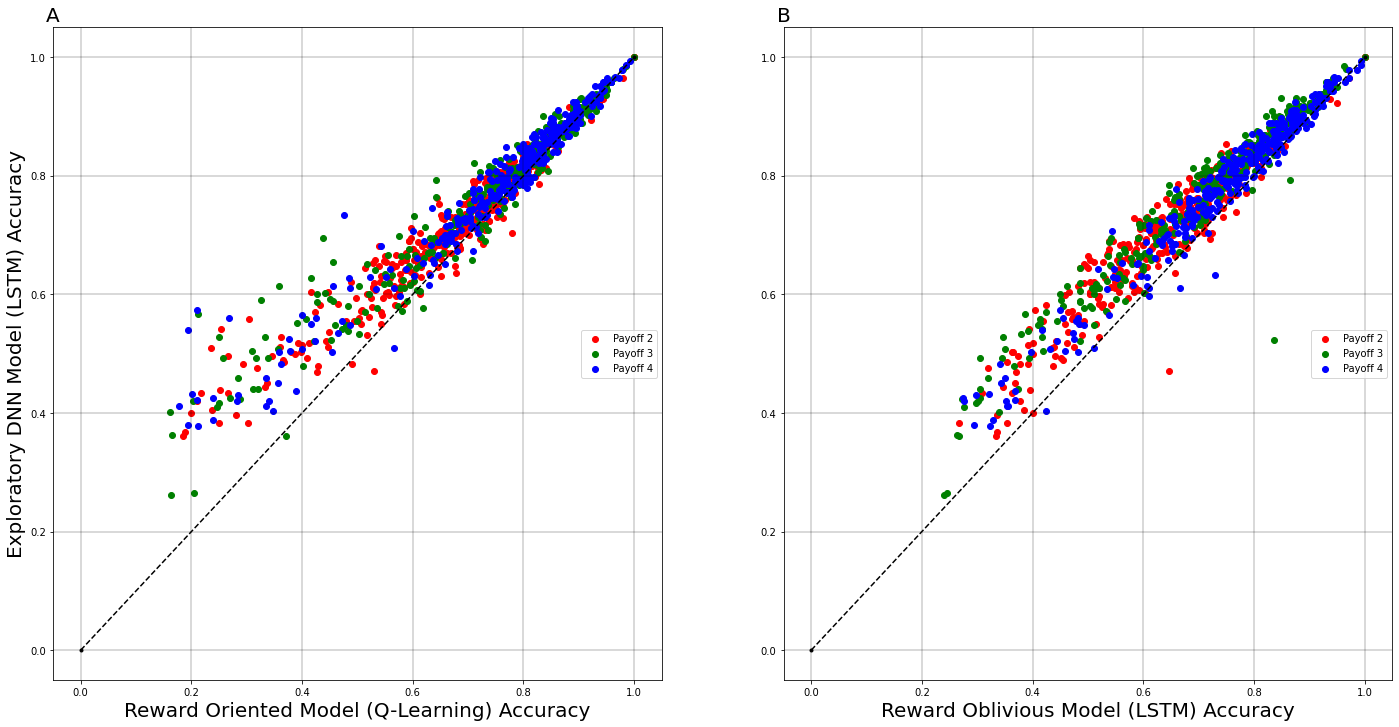

In [301]:
# 20.5.21 show both scatterplots together
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1, 1, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1, 1.0, 1, 1),  # white
    "savefig.facecolor": (1, 1.0, 1.0, 1),  # blue  with alpha = 20%
})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,12),frameon=False)


color_axes(axes[0])
axes[0].scatter(x=explicit_payoff2_accs, y=general_payoff2_accs, color ='r')
axes[0].scatter(x=explicit_payoff3_accs, y=general_payoff3_accs, color ='g')
axes[0].scatter(x=explicit_payoff4_accs, y=general_payoff4_accs, color ='b')
axes[0].legend(['Payoff 2','Payoff 3','Payoff 4'], loc= 'right')
x1, y1 = [0, 1], [0, 1]
axes[0].plot(x1, y1,'k--', marker = '.')
axes[0].set_xlabel('Reward Oriented Model (Q-Learning) Accuracy', fontdict=my_font_dict)
axes[0].set_ylabel('Exploratory DNN Model (LSTM) Accuracy', fontdict=my_font_dict)

x_range = np.arange(4,150)
color_axes(axes[1])
axes[1].scatter(x=nr_payoff2_accs, y=general_payoff2_accs, color ='r')
axes[1].scatter(x=nr_payoff3_accs, y=general_payoff3_accs, color ='g')
axes[1].scatter(x=nr_payoff4_accs, y=general_payoff4_accs, color ='b')
axes[1].legend(['Payoff 2','Payoff 3','Payoff 4'], loc= 'right')
x1, y1 = [0, 1], [0, 1]
axes[1].plot(x1, y1,'k--', marker = '.')
axes[1].set_xlabel('Reward Oblivious Model (LSTM) Accuracy', fontdict=my_font_dict)



axs = axes.flatten()
axs[0].set_title('A', fontsize=20, x=0)
axs[1].set_title('B', fontsize=20, x=0)


fig.savefig(os.path.join(saving_dir,'Participants accuracies panel.svg'),dpi=200, format='svg')
print(os.path.join(saving_dir,'Participants accuracies panel.svg'))